# HKL Model In 2 Dimensions

## 1. Density / Chemical Potential

### Setup

In [2]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

t = 1
d = 2

def I_1(x):
    if np.abs(x) <= 2*t:
        result = np.heaviside(x + 2*t, 1) - (1 / np.pi) * np.arccos(x / (2*t))
    else:
        result = np.heaviside(x + 2*t, 1)
    return result

def I_2(x):
    def I_1_shifted(k):
        return I_1(x + 2*t*np.cos(k))
    
    integral_value = integrate.quad(I_1_shifted, -np.pi, np.pi)
    
    return integral_value[0] / (2*np.pi)

def rho_hk_2d(mu, U):
    if U >= 0:
        return I_2(mu) + I_2(mu - U)
    elif U < 0:
        return 2 * I_2(mu - U/2)
    
def one_plot(x_array, y_array,x_label, y_label, title):
    plt.figure(dpi=100)
    # Plot erstellen
    plt.plot(x_array, y_array, linestyle='-')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.title(title)
    plt.show()

### Finding $\mu_{HKL}(\rho)$

In [3]:
def find_mu_of_rho_landau(rho, U, f_0):
    bracket = (-2*t*d, U + 2*t*d + 2*f_0) # minimal and maximal values of mu
    func_mu = lambda mu: rho_hk_2d(mu - f_0*rho, U) - rho
    result = root_scalar(func_mu, bracket=bracket, method='brentq')

    if result.converged:
        return result.root
    else:
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
rho_values = np.linspace(0, 2, 1000, endpoint=False)

def create_mu_list(rho_array, U, f_0):
    mu_values = []
    for rho_i in rho_array:
        print(rho_i)
        try:
            mu = find_mu_of_rho_landau(rho_i, U, f_0)
            mu_values.append(mu)
        except RuntimeError:
            mu_values.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")
    return mu_values

#mu_U_14_f0_0 = create_mu_list(rho_values, 14, 0)
#mu_U_14_f0_8 = create_mu_list(rho_values, 14, 8)
        
#one_plot(rho_values, mu_U_14_f0_0, r'$\rho$', r'$\mu$', r'$f_0 = 0$')
#one_plot(rho_values, mu_U_14_f0_8, r'$\rho$', r'$\mu$', r'$f_0 = 8$')

    

In [4]:
#one_plot(mu_U_14_f0_0, rho_values, r'$\mu$', r'$\rho$', r'$f_0 = 0$')
#one_plot(mu_U_14_f0_8, rho_values, r'$\mu$', r'$\rho$', r'$f_0 = 8$')

### Reset: Take mu array as base, calculate $\rho(\mu)$

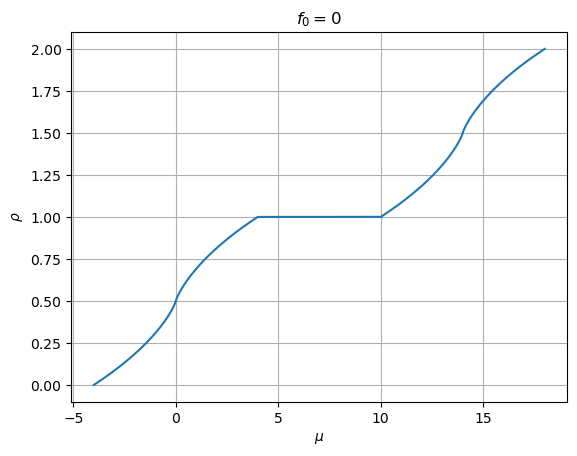

In [5]:
def find_rho_of_mu_landau(mu, U, f_0):
    bracket = (0, 2) # minimal and maximal values of rho
    func_mu = lambda rho: rho_hk_2d(mu - f_0*rho, U) - rho
    result = root_scalar(func_mu, bracket=bracket, method='brentq')

    if result.converged:
        return result.root
    else:
        raise RuntimeError(f"Keine Nullstelle gefunden für mu={mu}")

def create_mu_and_rho_arrays_landau(U, f_0, N):
    mu_array = np.linspace(-2*t*d, 2*t*d + U + 2*f_0, N)
    rho_list = []

    for mu_i in mu_array:
        rho_i = find_rho_of_mu_landau(mu_i, U, f_0)
        rho_list.append(rho_i)

    rho_array = np.array(rho_list)

    return mu_array, rho_array

mu_U14_f0, rho_U14_f0 = create_mu_and_rho_arrays_landau(14, 0, 1000)
one_plot(mu_U14_f0, rho_U14_f0, r'$\mu$', r'$\rho$', r'$f_0 = 0$')

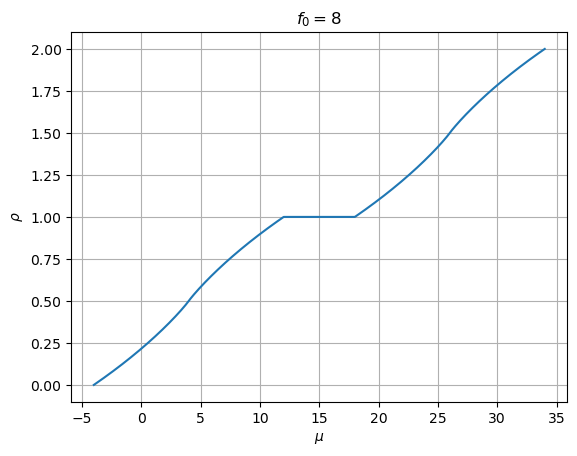

In [8]:
mu_U14_f8, rho_U14_f8 = create_mu_and_rho_arrays_landau(14, 8, 1000)
one_plot(mu_U14_f8, rho_U14_f8, r'$\mu$', r'$\rho$', r'$f_0 = 8$')

## 2. Compressibility

### Setup & Calculation

In [24]:
def DOS_HK_2D(E):
    def integrand_DOS_2d(k):
       if -1 < E/(2*t) + np.cos(k) < 1:
            integrand = 1 / np.sqrt(1 - (E/(2*t) + np.cos(k))**2)
            return integrand
       else:
            return 0
       
    int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)
    full_DOS = int_value[0] / (2 * np.pi**2 * t)
    return full_DOS

# CHECK FACTOR 1/2!
def kappa_hk_2d(mu, U):
    if U >= 0:
        return (DOS_HK_2D(mu) + DOS_HK_2D(mu - U)) / 2
    else:
        return DOS_HK_2D(mu - U/2)
    
def kappa_landau_2d(rho, mu, U, f_0):
    kappa_hk_renorm = kappa_hk_2d(mu - f_0 * rho, U)
    return kappa_hk_renorm / (1 + f_0 * kappa_hk_renorm)
    

def create_kappa_list(rho_array, mu_array, U, f_0):
    length = len(rho_array)
    kappa_list = []

    for i in range(length):
#        print(rho_array[i])
        try:
            kappa_i = kappa_landau_2d(rho_array[i], mu_array[i], U, f_0)
            kappa_list.append(kappa_i)
        except RuntimeError:
            kappa_list.append(np.nan)

    return kappa_list

kappa_U14_f0 = create_kappa_list(rho_U14_f0, mu_U14_f0, 14, 0)
kappa_U14_f8 = create_kappa_list(rho_U14_f8, mu_U14_f8, 14, 8)

/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/312585377.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)
/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/312585377.py:9: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)


### Plots $\kappa(\mu)$

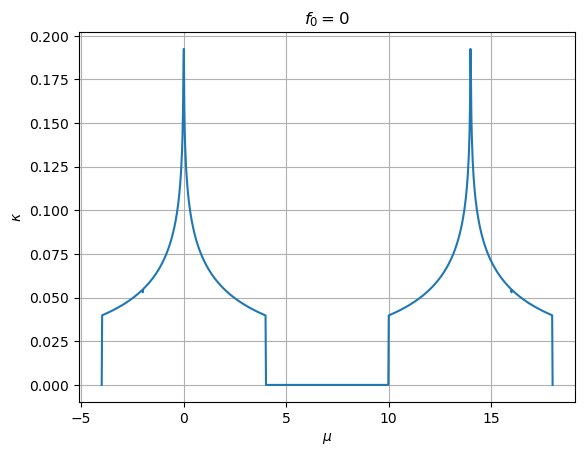

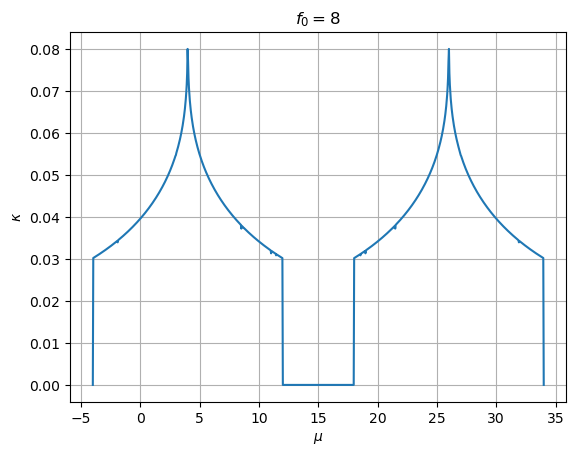

In [10]:
one_plot(mu_U14_f0, kappa_U14_f0, r'$\mu$', r'$\kappa$', r'$f_0=0$')
one_plot(mu_U14_f8, kappa_U14_f8, r'$\mu$', r'$\kappa$', r'$f_0=8$')

Grenzwert 1/f_0 leider nicht gut erkennbar, denke wegen logarithmischer Divergenz vs. 1/x Divergenz im 1d Case. Verbessere Numerik um Divergenz herum?

### Plots $\kappa(\rho)$

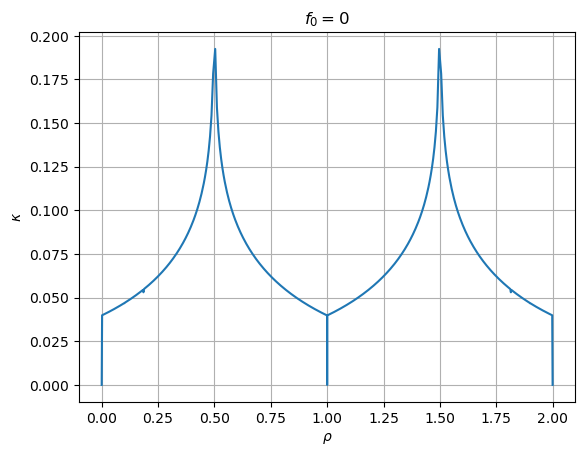

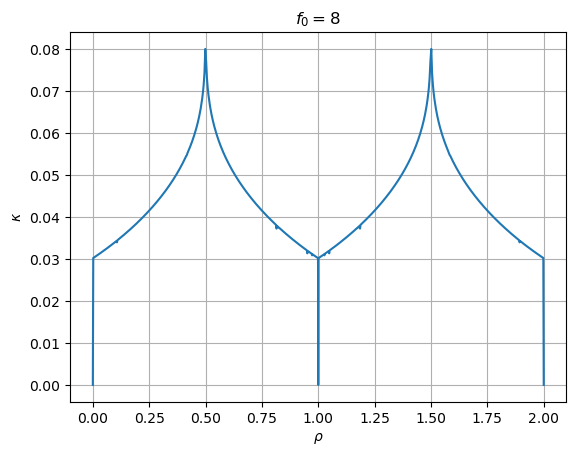

In [25]:
one_plot(rho_U14_f0, kappa_U14_f0, r'$\rho$', r'$\kappa$', r'$f_0=0$')
one_plot(rho_U14_f8, kappa_U14_f8, r'$\rho$', r'$\kappa$', r'$f_0=8$')

### Improving Numerical Accuracy Around Singularity

Singularities are Present for $\rho = 0.5$ and $\rho = 1.5$ for $U > U_c$

#### $f_0=0$ Case (HK Model)

0.499
0.49900100050025015
0.49900200100050024
0.4990030015007504
0.4990040020010005
0.4990050025012506
0.4990060030015008
0.49900700350175087
0.499008004002001
0.4990090045022511
0.49901000500250126
0.49901100550275135
0.4990120060030015
0.49901300650325164
0.49901400700350174
0.4990150075037519
0.499016008004002
0.4990170085042521
0.49901800900450227
0.49901900950475236
0.4990200100050025
0.4990210105052526
0.49902201100550275
0.4990230115057529
0.499024012006003
0.49902501250625314
0.49902601300650323
0.4990270135067534
0.49902801400700353
0.4990290145072536
0.49903001500750377
0.49903101550775386
0.499032016008004
0.4990330165082541
0.49903401700850425
0.4990350175087544
0.4990360180090045
0.49903701850925464
0.49903801900950473
0.4990390195097549
0.499040020010005
0.4990410205102551
0.49904202101050527
0.49904302151075536
0.4990440220110055
0.49904502251125565
0.49904602301150575
0.4990470235117559
0.499048024012006
0.49904902451225613
0.4990500250125062
0.4990510255127564
0.499052

/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/3767520486.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_value = integrate.quad(I_1_shifted, -np.pi, np.pi)


0.4999384692346173
0.4999394697348674
0.49994047023511756
0.4999414707353677
0.4999424712356178
0.49994347173586795
0.49994447223611804
0.4999454727363682
0.4999464732366183
0.49994747373686843
0.4999484742371186
0.49994947473736867
0.4999504752376188
0.4999514757378689
0.49995247623811906
0.4999534767383692
0.4999544772386193
0.49995547773886945
0.49995647823911954
0.4999574787393697
0.49995847923961984
0.4999594797398699
0.4999604802401201
0.49996148074037017
0.4999624812406203
0.4999634817408704
0.49996448224112056
0.4999654827413707
0.4999664832416208
0.49996748374187094
0.49996848424212104
0.4999694847423712
0.49997048524262133
0.4999714857428714
0.49997248624312157
0.49997348674337166
0.4999744872436218
0.49997548774387196
0.49997648824412205
0.4999774887443722
0.4999784892446223
0.49997948974487244
0.4999804902451226
0.4999814907453727
0.49998249124562283
0.4999834917458729
0.49998449224612307
0.49998549274637316
0.4999864932466233
0.49998749374687346
0.49998849424712355
0.49998

/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/312585377.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)


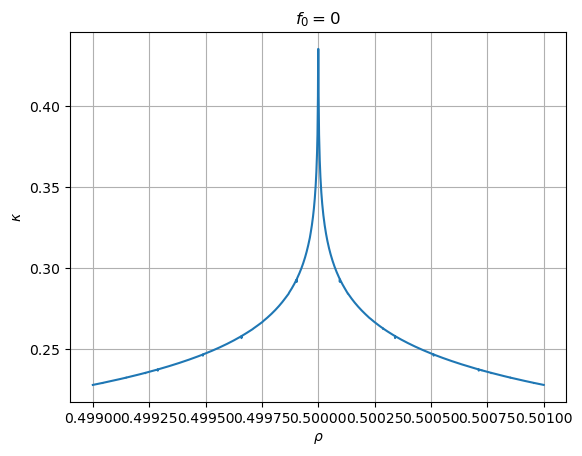

In [27]:
rho_U14_f0_sing_1 = np.linspace(0.499, 0.501, 2000)
#rho_U14_f0_sing_2 = np.linspace(0.499, 0.501, 2000)

mu_U14_f0_sing_1 = create_mu_list(rho_U14_f0_sing_1, 14, 0)
#mu_U14_f0_sing_2 = create_mu_list(rho_U14_f0_sing_2, 14, 0)

kappa_U14_f0_sing_1 = create_kappa_list(rho_U14_f0_sing_1, mu_U14_f0_sing_1, 14, 0)
#kappa_U14_f0_sing_2 = create_kappa_list(rho_U14_f0_sing_2, mu_U14_f0_sing_2, 14, 0)

one_plot(rho_U14_f0_sing_1, kappa_U14_f0_sing_1, r'$\rho$', r'$\kappa$', r'$f_0=0$')
#one_plot(rho_U14_f0_sing_2, kappa_U14_f0_sing_2, r'$\rho$', r'$\kappa$', r'$f_0=0$')

#### $f_0 = 8$

0.499999
0.4999990005
0.49999900100000005
0.49999900150000004


/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/3767520486.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_value = integrate.quad(I_1_shifted, -np.pi, np.pi)


0.499999002
0.4999990025
0.49999900300000005
0.49999900350000004
0.499999004
0.4999990045
0.49999900500000005
0.49999900550000004
0.499999006
0.4999990065
0.49999900700000005
0.49999900750000004
0.499999008
0.4999990085
0.49999900900000005
0.49999900950000004
0.49999901
0.4999990105
0.49999901100000005
0.49999901150000003
0.499999012
0.4999990125
0.49999901300000005
0.49999901350000003
0.499999014
0.4999990145
0.49999901500000005
0.49999901550000003
0.499999016
0.4999990165
0.49999901700000005
0.49999901750000003
0.499999018
0.4999990185
0.49999901900000004
0.49999901950000003
0.49999902
0.4999990205
0.49999902100000004
0.49999902150000003
0.499999022
0.4999990225
0.49999902300000004
0.49999902350000003
0.499999024
0.4999990245
0.49999902500000004
0.4999990255
0.499999026
0.4999990265
0.49999902700000004
0.4999990275
0.499999028
0.49999902850000005
0.49999902900000004
0.4999990295
0.49999903
0.49999903050000005
0.49999903100000004
0.4999990315
0.499999032
0.49999903250000005
0.49999903

/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/312585377.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)
/var/folders/6g/kfvfxvvs2473z8z47g0kr34w0000gn/T/ipykernel_11490/312585377.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_value = integrate.quad(integrand_DOS_2d, 0, np.pi)


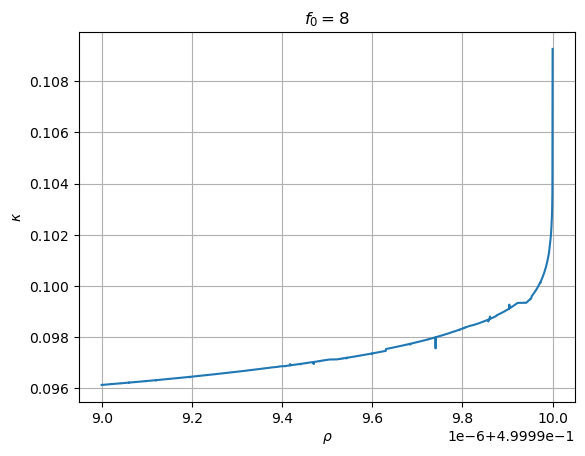

In [31]:
rho_U14_f8_sing_1 = np.linspace(0.499999, 0.5, 2001)
#rho_U14_f8_sing_2 = np.linspace(1.499, 1.501, 1000)

mu_U14_f8_sing_1 = create_mu_list(rho_U14_f8_sing_1, 14, 8)
#mu_U14_f8_sing_2 = create_mu_list(rho_U14_f8_sing_2, 14, 8)

kappa_U14_f8_sing_1 = create_kappa_list(rho_U14_f8_sing_1, mu_U14_f8_sing_1, 14, 8)
#kappa_U14_f8_sing_2 = create_kappa_list(rho_U14_f8_sing_2, mu_U14_f8_sing_2, 14, 8)

one_plot(rho_U14_f8_sing_1, kappa_U14_f8_sing_1, r'$\rho$', r'$\kappa$', r'$f_0=8$')
#one_plot(rho_U14_f8_sing_2, kappa_U14_f8_sing_2, r'$\rho$', r'$\kappa$', r'$f_0=8$')